In [53]:

import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import wordnet as wn
nltk.download('stopwords')
nltk.download('wordnet')
# spacy for lemmatization
import spacy
from spacy.lang.en import English
parser = English()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

with open("../data/all_reviews.pkl","rb") as f:
    reviews = pickle.load(f)
    
job_filter = pd.read_csv("../data/filter_job_titles.csv")

job_filters = job_filter.clean_job_title.tolist()

idx = reviews.clean_job_title.isin(job_filters)
reviews = reviews.loc[idx,:]

print( reviews.shape )
reviews.reset_index(drop=True,inplace=True)
display( reviews.head() )

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Allen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(61122, 15)


,company_name,review_title,job_title,employee_status,location,date,review,pros,cons,rating,yes_helpful,no_helpful,industry,clean_job_title,language
0,EY,I had a great time working at EY,Software Developer,Former Employee,"Bengaluru, Karnataka",2020-03-02,Pros:\rGreat Learning Curve.\rPeer Culture is ...,NaN,NaN,4.0,0,0,accounting,software developer,en
1,EY,Great place to be,Office Administrator/Receptionist,Former Employee,Cork,2020-02-28,A lovely team and very pretty environment. I f...,NaN,NaN,5.0,0,0,accounting,office administrator receptionist,en
2,EY,Productive and FUN Place,System Engineer,Current Employee,"Hyderabad, Telangana",2020-02-25,It's feel like workplace where can utilize kno...,NaN,NaN,5.0,0,0,accounting,system engineer,en
3,EY,Fun to work at and has the best Work Culture,Associate Software Engineer,Former Employee,Bengaluru,2020-02-15,Supportive peers and leaders who are always pr...,NaN,NaN,5.0,0,0,accounting,associate software engineer,en
4,EY,Good Environment,Desktop Support Administrator & Business Opera...,Current Employee,"Nashville, TN",2020-01-24,EY is a very nice environment to work at. Tec...,NaN,NaN,4.0,0,0,accounting,desktop support administrator business operati...,en


In [2]:
#NLTK Stop words

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#extend stop word based on top 50 words
stop_words.extend(["new","lot","get","many","also","day","part","one","things","always","years","really"])

In [3]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [4]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [5]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [6]:
processed_docs = reviews['review'].map(prepare_text_for_lda)
processed_docs[:10]


0    [great, learning, curve, culture, great, balan...
1    [lovely, pretty, environment, welcome, great, ...
2    [workplace, utilize, knowledge, skill, managem...
3    [supportive, peer, leaders, present, guide, te...
4    [environment, tech, player, learn, something, ...
5    [energetic, vibrant, company, extrovert, deali...
6    [place, learn, technology, culture, awesome, p...
7    [flexibility, management, employee, benefit, i...
8    [help, family, bring, final, fruitful, result,...
9    [excellent, company, perfect, culture, annual,...
Name: review, dtype: object

In [7]:
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(text) for text in processed_docs]

In [8]:
num_topics = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=15)
#ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.107*"career" + 0.072*"start" + 0.030*"training" + 0.030*"place"')
(1, '0.344*"project" + 0.029*"complete" + 0.028*"given" + 0.016*"deadline"')
(2, '0.040*"technology" + 0.030*"skill" + 0.022*"company" + 0.019*"provide"')
(3, '0.056*"customer" + 0.030*"client" + 0.024*"issue" + 0.018*"typical"')
(4, '0.020*"system" + 0.017*"software" + 0.017*"application" + 0.013*"development"')
(5, '0.033*"management" + 0.026*"manager" + 0.016*"employee" + 0.015*"company"')
(6, '0.097*"learn" + 0.043*"working" + 0.039*"management" + 0.032*"place"')
(7, '0.054*"company" + 0.044*"great" + 0.043*"people" + 0.029*"working"')
(8, '0.064*"company" + 0.054*"employee" + 0.040*"balance" + 0.036*"management"')
(9, '0.071*"genpact" + 0.054*"wipro" + 0.034*"join" + 0.022*"center"')


In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics = num_topics ,id2word=dictionary, passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_docs, start=2, limit=30, step=3)

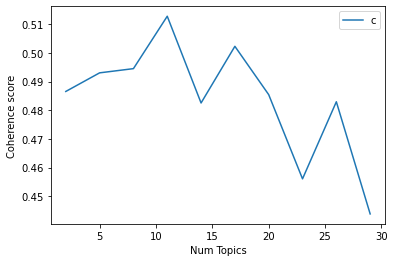

In [11]:
# Show graph
limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4866
Num Topics = 5  has Coherence Value of 0.4931
Num Topics = 8  has Coherence Value of 0.4945
Num Topics = 11  has Coherence Value of 0.5128
Num Topics = 14  has Coherence Value of 0.4825
Num Topics = 17  has Coherence Value of 0.5023
Num Topics = 20  has Coherence Value of 0.4855
Num Topics = 23  has Coherence Value of 0.4561
Num Topics = 26  has Coherence Value of 0.483
Num Topics = 29  has Coherence Value of 0.4438


In [13]:
model_list

In [14]:
coherence_values

[0.4865718814971993,
 0.4930692680836322,
 0.49453991015761783,
 0.5128364200829613,
 0.48254969920363516,
 0.5023342781690596,
 0.4854560934507278,
 0.4560550233746873,
 0.4829735903525999,
 0.4438084459428746]

In [24]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.045*"learn" + 0.039*"management" + 0.036*"hard" + 0.034*"customer" + '
  '0.030*"enjoyable" + 0.028*"worker" + 0.025*"client" + 0.022*"typical" + '
  '0.020*"project" + 0.020*"issue"'),
 (1,
  '0.102*"company" + 0.066*"employee" + 0.025*"great" + 0.021*"would" + '
  '0.014*"people" + 0.013*"change" + 0.013*"recommend" + 0.011*"culture" + '
  '0.010*"place" + 0.009*"family"'),
 (2,
  '0.054*"contract" + 0.035*"mahindra" + 0.031*"join" + 0.027*"terms" + '
  '0.025*"capgemini" + 0.023*"month" + 0.020*"hike" + 0.019*"college" + '
  '0.017*"limited" + 0.014*"programming"'),
 (3,
  '0.057*"working" + 0.055*"environment" + 0.048*"great" + 0.044*"place" + '
  '0.041*"learn" + 0.041*"management" + 0.037*"friendly" + 0.033*"culture" + '
  '0.024*"company" + 0.022*"enjoy"'),
 (4,
  '0.035*"company" + 0.027*"wipro" + 0.024*"services" + 0.021*"technology" + '
  '0.019*"large" + 0.018*"business" + 0.017*"client" + 0.017*"india" + '
  '0.016*"domain" + 0.016*"service"'),
 (5,
  '0.029*"soft

In [29]:
lda_display = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [17]:
current_empl_doc = reviews.review[reviews["employee_status"]=="Current Employee"].map(prepare_text_for_lda)
former_empl_doc = reviews.review[reviews["employee_status"]=="Former Employee"].map(prepare_text_for_lda)

In [18]:
current_empl_doc.reset_index(drop=True,inplace=True)
former_empl_doc.reset_index(drop=True,inplace=True)

In [19]:
display(current_empl_doc[:10])
display(former_empl_doc[:10])

0    [workplace, utilize, knowledge, skill, managem...
1    [environment, tech, player, learn, something, ...
2    [energetic, vibrant, company, extrovert, deali...
3    [place, learn, technology, culture, awesome, p...
4    [flexibility, management, employee, benefit, i...
5    [help, family, bring, final, fruitful, result,...
6    [excellent, company, perfect, culture, annual,...
7    [ernst, large, company, benefit, flexibility, ...
8    [experience, people, culture, balance, awesome...
9    [helping, culture, learn, technology, people, ...
Name: review, dtype: object

0    [great, learning, curve, culture, great, balan...
1    [lovely, pretty, environment, welcome, great, ...
2    [supportive, peer, leaders, present, guide, te...
3    [brand, value, little, learning, growth, oppor...
4    [challenge, inclusive, quiet, reserve, strange...
5    [place, senior, consider, salary, benefit, com...
6    [office, hours, stressful, people, helpful, ac...
7    [place, friendly, environment, learn, field, s...
8    [great, workplace, start, career, hours, somet...
9           [place, competitive, compensation, growth]
Name: review, dtype: object

In [20]:
dictionary_current_empl = corpora.Dictionary(current_empl_doc)
corpus_current_empl = [dictionary_current_empl.doc2bow(text) for text in current_empl_doc]

dictionary_former_empl = corpora.Dictionary(former_empl_doc)
corpus_former_empl = [dictionary_former_empl.doc2bow(text) for text in former_empl_doc]

In [21]:
model_list_current, coherence_values_current = compute_coherence_values(dictionary=dictionary_current_empl, corpus=corpus_current_empl, texts=current_empl_doc, start=2, limit=30, step=3)
model_list_former, coherence_values_former = compute_coherence_values(dictionary=dictionary_former_empl, corpus=corpus_former_empl, texts=former_empl_doc, start=2, limit=30, step=3)

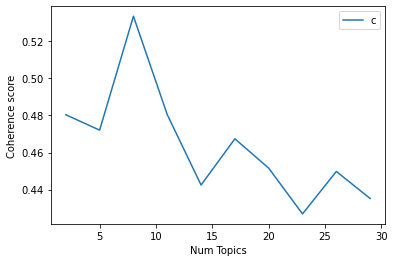

In [22]:
# Show graph
limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values_current)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values for Current Employee"), loc='best')
plt.show()

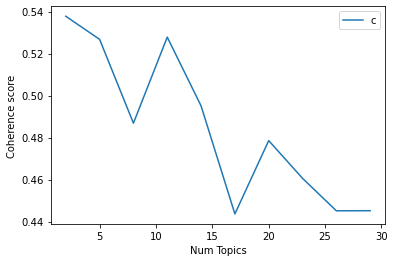

In [25]:
# Show graph
limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values_former)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values for Former Employee"), loc='best')
plt.show()

In [28]:
# Print the coherence scores
print("*"*10+"Current Employee Coherence Value"+"*"*10)
for m, cv in zip(x, coherence_values_current):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
print("*"*10+"Former Employee Coherence Value"+"*"*10)    
# Print the coherence scores
for m, cv in zip(x, coherence_values_former):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

**********Current Employee Coherence Value**********
Num Topics = 2  has Coherence Value of 0.4804
Num Topics = 5  has Coherence Value of 0.4721
Num Topics = 8  has Coherence Value of 0.5335
Num Topics = 11  has Coherence Value of 0.4805
Num Topics = 14  has Coherence Value of 0.4425
Num Topics = 17  has Coherence Value of 0.4674
Num Topics = 20  has Coherence Value of 0.4516
Num Topics = 23  has Coherence Value of 0.4269
Num Topics = 26  has Coherence Value of 0.4498
Num Topics = 29  has Coherence Value of 0.4352
**********Former Employee Coherence Value**********
Num Topics = 2  has Coherence Value of 0.5378
Num Topics = 5  has Coherence Value of 0.5268
Num Topics = 8  has Coherence Value of 0.4869
Num Topics = 11  has Coherence Value of 0.5279
Num Topics = 14  has Coherence Value of 0.4951
Num Topics = 17  has Coherence Value of 0.4436
Num Topics = 20  has Coherence Value of 0.4786
Num Topics = 23  has Coherence Value of 0.4606
Num Topics = 26  has Coherence Value of 0.4451
Num Topi

In [32]:
# Select the model and print the topics for current employee reviews
optimal_model_current = model_list_current[2]
model_topics_current = optimal_model_current.show_topics(formatted=False)
pprint(optimal_model_current.print_topics(num_words=10))

[(0,
  '0.074*"learn" + 0.046*"working" + 0.040*"management" + 0.030*"environment" '
  '+ 0.027*"worker" + 0.022*"place" + 0.020*"enjoy" + 0.019*"friendly" + '
  '0.018*"culture" + 0.018*"enjoyable"'),
 (1,
  '0.061*"company" + 0.043*"employee" + 0.034*"management" + 0.029*"salary" + '
  '0.028*"culture" + 0.026*"balance" + 0.026*"project" + 0.018*"working" + '
  '0.018*"benefit" + 0.015*"place"'),
 (2,
  '0.025*"server" + 0.024*"application" + 0.023*"experience" + 0.023*"various" '
  '+ 0.019*"system" + 0.016*"using" + 0.015*"knowledge" + 0.013*"database" + '
  '0.012*"oracle" + 0.011*"tool"'),
 (3,
  '0.019*"nothing" + 0.014*"target" + 0.011*"review" + 0.010*"amazon" + '
  '0.010*"write" + 0.008*"quickly" + 0.008*"notice" + 0.008*"simply" + '
  '0.008*"minimum" + 0.007*"layoff"'),
 (4,
  '0.054*"great" + 0.051*"company" + 0.041*"opportunity" + 0.041*"place" + '
  '0.031*"career" + 0.031*"learn" + 0.025*"technology" + 0.017*"environment" + '
  '0.017*"start" + 0.017*"learning"'),
 (5,

In [31]:
# Select the model and print the topics for former employee reviews
optimal_model_former = model_list_former[3]
model_topics_former = optimal_model_former.show_topics(formatted=False)
pprint(optimal_model_former.print_topics(num_words=10))

[(0,
  '0.080*"learn" + 0.049*"working" + 0.047*"great" + 0.041*"management" + '
  '0.035*"environment" + 0.033*"place" + 0.027*"experience" + 0.025*"skill" + '
  '0.024*"friendly" + 0.023*"culture"'),
 (1,
  '0.034*"management" + 0.021*"manager" + 0.019*"position" + 0.017*"month" + '
  '0.015*"contract" + 0.015*"change" + 0.013*"hire" + 0.012*"level" + '
  '0.011*"company" + 0.009*"mahindra"'),
 (2,
  '0.036*"system" + 0.020*"support" + 0.018*"application" + 0.016*"server" + '
  '0.015*"using" + 0.015*"create" + 0.013*"report" + 0.012*"work" + '
  '0.012*"requirement" + 0.012*"database"'),
 (3,
  '0.051*"customer" + 0.023*"client" + 0.019*"issue" + 0.019*"typical" + '
  '0.018*"meeting" + 0.018*"hard" + 0.016*"service" + 0.015*"need" + '
  '0.015*"daily" + 0.014*"enjoyable"'),
 (4,
  '0.067*"great" + 0.056*"benefit" + 0.054*"salary" + 0.041*"company" + '
  '0.038*"place" + 0.025*"compensation" + 0.024*"balance" + '
  '0.019*"advancement" + 0.019*"management" + 0.017*"culture"'),
 (5,


In [33]:
lda_display_current = pyLDAvis.gensim.prepare(optimal_model_current, corpus_current_empl, dictionary_current_empl, sort_topics=False)
pyLDAvis.display(lda_display_current)

In [34]:
lda_display_former = pyLDAvis.gensim.prepare(optimal_model_former, corpus_former_empl, dictionary_former_empl, sort_topics=False)
pyLDAvis.display(lda_display_former)

An HDP model is fully unsupervised. It can also determine the ideal number of topics it needs through posterior inference.

In [49]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary,T=20)

C:\Users\Allen\miniconda3\envs\capstone\lib\site-packages\gensim\models\hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


In [50]:
hdpmodel.show_topics()

[(0,
  '0.015*company + 0.012*management + 0.011*learn + 0.011*great + 0.010*working + 0.008*place + 0.008*project + 0.008*employee + 0.007*people + 0.007*environment + 0.006*experience + 0.006*culture + 0.005*opportunity + 0.005*manager + 0.005*technology + 0.005*work + 0.004*balance + 0.004*provide + 0.004*client + 0.004*skill'),
 (1,
  '0.008*company + 0.006*learn + 0.006*great + 0.006*management + 0.005*working + 0.005*place + 0.004*environment + 0.004*employee + 0.004*people + 0.004*culture + 0.003*project + 0.003*opportunity + 0.003*experience + 0.003*balance + 0.003*technology + 0.002*manager + 0.002*career + 0.002*work + 0.002*learning + 0.002*benefit'),
 (2,
  '0.008*company + 0.006*learn + 0.006*great + 0.006*management + 0.005*place + 0.005*working + 0.004*environment + 0.004*employee + 0.004*people + 0.003*culture + 0.003*project + 0.003*opportunity + 0.003*experience + 0.003*balance + 0.003*technology + 0.002*manager + 0.002*work + 0.002*career + 0.002*learning + 0.002*ben

In [51]:
lda_display_HDP = pyLDAvis.gensim.prepare(hdpmodel, corpus, dictionary)
pyLDAvis.display(lda_display_HDP)